In [1]:
import cv2

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

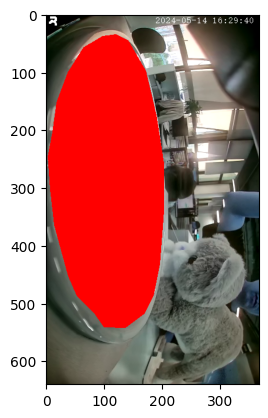

(640, 368, 3)


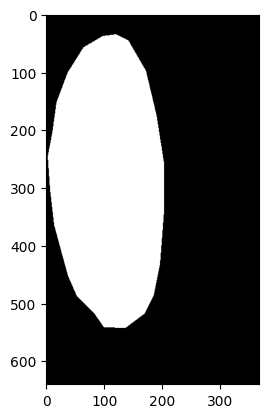

In [28]:
primary_mask = cv2.imread("primary_mask.png")

primary_mask = cv2.cvtColor(primary_mask, cv2.COLOR_BGR2RGB)
plt.imshow(primary_mask)
plt.show()
print(primary_mask.shape)
for i in range(primary_mask.shape[0]):
    for j in range(primary_mask.shape[1]):
        if primary_mask[i,j,0] >= 230 and primary_mask[i,j,1] <= 20 and primary_mask[i,j,2] <= 20:
            primary_mask[i,j,0] = 255
            primary_mask[i,j,1] = 255
            primary_mask[i,j,2] = 255
            continue
        else:
            primary_mask[i,j,0] = 0
            primary_mask[i,j,1] = 0
            primary_mask[i,j,2] = 0
plt.imshow(primary_mask)
plt.show()
primary_mask = primary_mask.astype(np.uint8)

In [29]:
video_path = r'AI数据样本\瓷碗出粮（3种粮）+碗内余粮+积粮\1715675377828.mp4'
capture = cv2.VideoCapture(video_path)

count = 0
frame1, frame2 = None, None
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    if count == 100:
        frame1 = frame
        # 使用primary_mask进行抠图
        frame1 = cv2.bitwise_and(frame1, frame1, mask=primary_mask[:,:,0])
    if count == 3000:
        frame2 = frame
        frame2 = cv2.bitwise_and(frame2, frame2, mask=primary_mask[:,:,0])
    elif count >= 5000:
        break
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
capture.release()

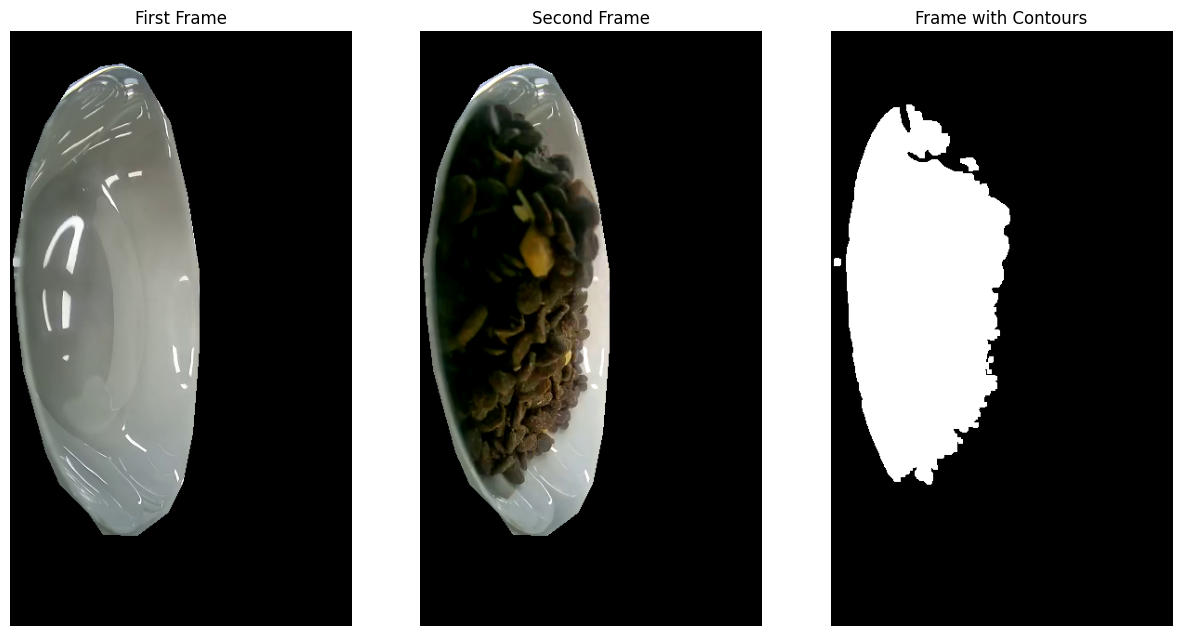

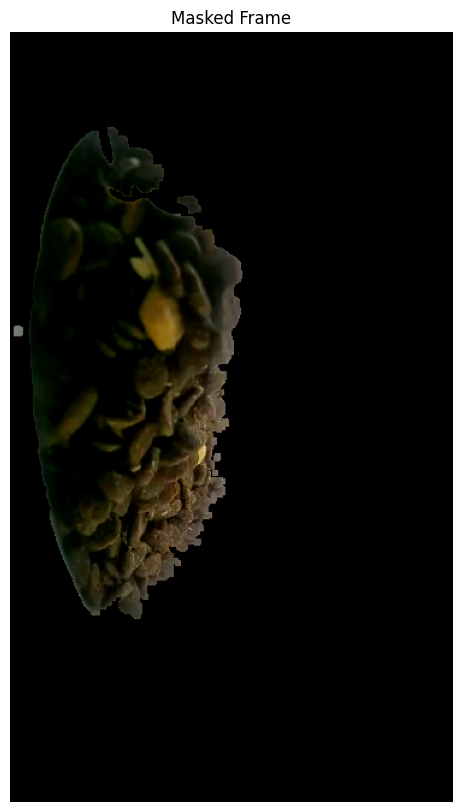

ret: 22265767.406594068
label: 2 (235520, 1)
center: [[5.1343393e-01 8.5274315e-01 4.8781976e-02]
 [9.6834175e+01 8.2009308e+01 5.2650108e+01]
 [4.3764320e+01 3.9134472e+01 1.4214426e+01]]
colors: [(0, 0, 0), (96, 82, 52), (43, 39, 14)]
pet_food_colors: [(96, 82, 52), (43, 39, 14)]
label: (235520, 1) [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


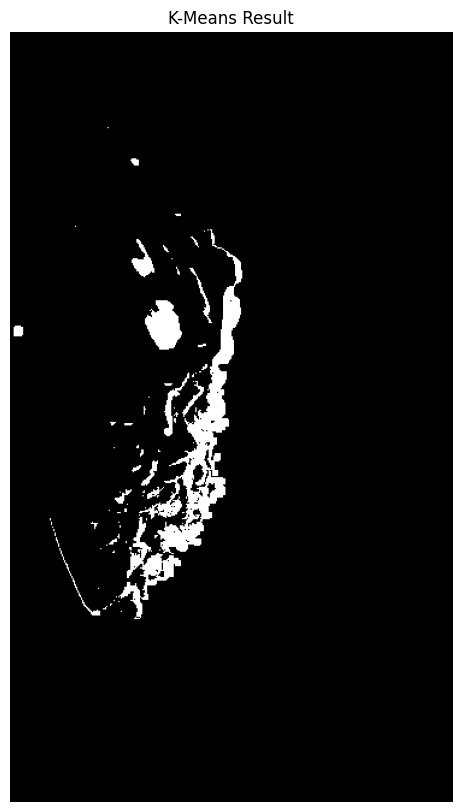

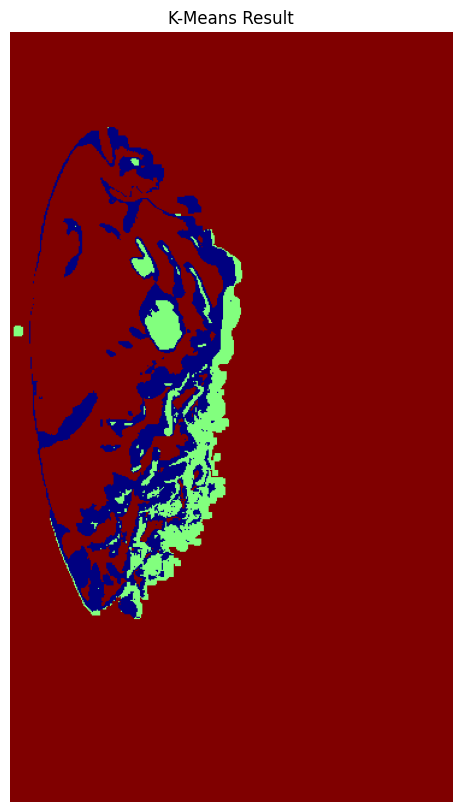

In [35]:
def diff_image(f1, f2):

    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 找前十个最大连通域
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # 将前十个连通域转换成mask
    mask = np.zeros(frame1.shape, np.uint8)
    for contour in contours:
        cv2.drawContours(mask, [contour], 0, 255, -1)
    # max_contour = max(contours, key=cv2.contourArea)

    # # 将最大连通域转换程mask
    # mask = np.zeros(frame1.shape, np.uint8)
    # cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('First Frame')
    plt.imshow(f1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Second Frame')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    # 显示抠出来的帧
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_frame)
    plt.axis('off')
    plt.title('Masked Frame')
    plt.show()


    # # 使用kmeans算法聚类, 忽略0的像素值
    # masked_frame[masked_frame == 0] = 255
    # plt.imshow(masked_frame)
    # plt.title('masked_frame')
    # plt.show()

    Z = masked_frame.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 3
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # 解释kmeans的输出
    print('ret:', ret)
    print('label:', np.max(label), label.shape)
    print('center:', center)

    # 打印center的颜色
    colors = []
    for i in range(K):
        colors.append((int(center[i][0]), int(center[i][1]), int(center[i][2])))
    print('colors:', colors)

    # 挑选Blue通道是三个通道中最小的颜色
    pet_food_colors = []
    for color in colors:
        if color[2] < color[0] and color[2] < color[1]:
            pet_food_colors.append(color)
    print('pet_food_colors:', pet_food_colors)

    # 显示每个像素的聚类结果
    print('label:', label.shape, label[:10,:])
    result = label.reshape((masked_frame.shape[:2]))

    label1 = result.copy()
    label1[np.where(label1 != 1)] = 0
    label1[np.where(label1 == 1)] = 255
    plt.figure(figsize=(10, 10))
    plt.imshow(label1, cmap='gray')
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()

    # colormap
    result = result.astype(np.float32)
    result = result / np.max(result) * 255
    result = cv2.applyColorMap(result.astype(np.uint8), cv2.COLORMAP_JET)
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()



diff_image(frame1, frame2)

In [ ]:


def diff_image2(f1, f2):

    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 找前十个最大连通域
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # 将前十个连通域转换成mask
    mask = np.zeros(frame1.shape, np.uint8)
    for contour in contours:
        cv2.drawContours(mask, [contour], 0, 255, -1)
    # max_contour = max(contours, key=cv2.contourArea)

    # # 将最大连通域转换程mask
    # mask = np.zeros(frame1.shape, np.uint8)
    # cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('First Frame')
    plt.imshow(f1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Second Frame')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    # 显示抠出来的帧
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_frame)
    plt.axis('off')
    plt.title('Masked Frame')
    plt.show()


    # # 使用kmeans算法聚类, 忽略0的像素值
    # masked_frame[masked_frame == 0] = 255
    # plt.imshow(masked_frame)
    # plt.title('masked_frame')
    # plt.show()

    Z = masked_frame.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 3
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # 解释kmeans的输出
    print('ret:', ret)
    print('label:', np.max(label), label.shape)
    print('center:', center)

    # 打印center的颜色
    colors = []
    for i in range(K):
        colors.append((int(center[i][0]), int(center[i][1]), int(center[i][2])))
    print('colors:', colors)

    # 挑选Blue通道是三个通道中最小的颜色
    pet_food_colors = []
    for color in colors:
        if color[2] < color[0] and color[2] < color[1]:
            pet_food_colors.append(color)
    print('pet_food_colors:', pet_food_colors)

    # 显示每个像素的聚类结果
    print('label:', label.shape, label[:10,:])
    result = label.reshape((masked_frame.shape[:2]))

    label1 = result.copy()
    label1[np.where(label1 != 1)] = 0
    label1[np.where(label1 == 1)] = 255
    plt.figure(figsize=(10, 10))
    plt.imshow(label1, cmap='gray')
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()

    # colormap
    result = result.astype(np.float32)
    result = result / np.max(result) * 255
    result = cv2.applyColorMap(result.astype(np.uint8), cv2.COLORMAP_JET)
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()



diff_image(frame1, frame2)

In [ ]:
def diff_image(f1, f2):

    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    max_contour = max(contours, key=cv2.contourArea)

    # 将最大连通域转换程mask
    mask = np.zeros(frame1.shape, np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    return masked_frame
    